# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary.

**Business Understanding:** The question that we want to answer is "What factors make a car more or less expensive?". To create an estimation model that answers this question we first need to get datasets that contain the vehicle price information and multiple features associated to it. We will use the "vehicles.csv" dataset. Then we will understand, prepare, and model the data to answer which features, and their weights, drive the price of vehicles.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

**Load**: The necessary packages.

In [107]:
!pip install category_encoders
from category_encoders import JamesSteinEncoder
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import make_column_transformer
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import pandas as pd
import numpy as np
import seaborn as sns

**Load**: The vehicle data.

In [108]:
vehicles = pd.read_csv('vehicles.csv.zip')

**Analyze**: The columns names, types, and percentage of Null values

In [109]:
vehicles.info()
# Need to convert object to string.
(vehicles.isnull().sum() / len(vehicles)).mul(100).round(2).astype(str).add('%').rename('Percentage of Nulls')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880 non-null  object 
dtypes: f

,Percentage of Nulls
id,0.0%
region,0.0%
price,0.0%
year,0.28%
manufacturer,4.13%
model,1.24%
condition,40.79%
cylinders,41.62%
fuel,0.71%
odometer,1.03%


**Conclusions:** There are multiple columns of type object instead of a clear data type. Columns "condition" (40.79%), "cylinders" (41.62%), "VIN" (37.73%), "drive" (30.59%), "size" (71.77%), "type" (21.75%), and "paint_color" (30.5%) have a high perceptage of Null values.

**Analyze:** Histogram of "price" column.

,Percentage of 0
odometer,0.46%
price,7.71%
year,0.0%


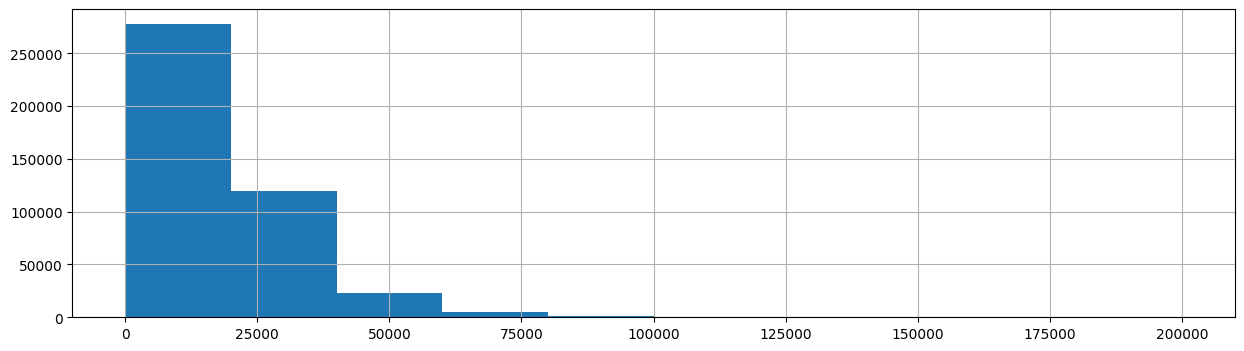

In [110]:
plt.figure(figsize=(15,4))
vehicles['price'].drop(vehicles[vehicles['price'].gt(200000)].index).hist()
(vehicles[['odometer', 'price', 'year']].eq(0).sum() / len(vehicles)).mul(100).round(2).astype(str).add('%').rename('Percentage of 0')

**Conclusion:** The majority of prices are between 0..100000. There are some outliers after 100000 that we can drop. The "price" column has a 7.71% of 0 values and "odometer" column has a 0.46% of 0 values.

**Analyze:** The distribution of values inside categorical columns and the mode.

Number of unique values in "model" column: 29650
Number of unique values in "region" column: 404


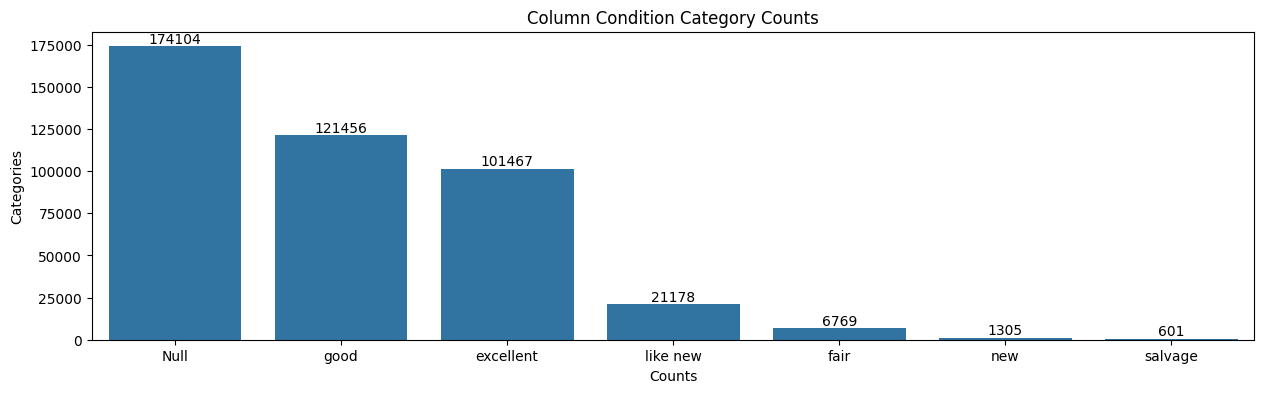

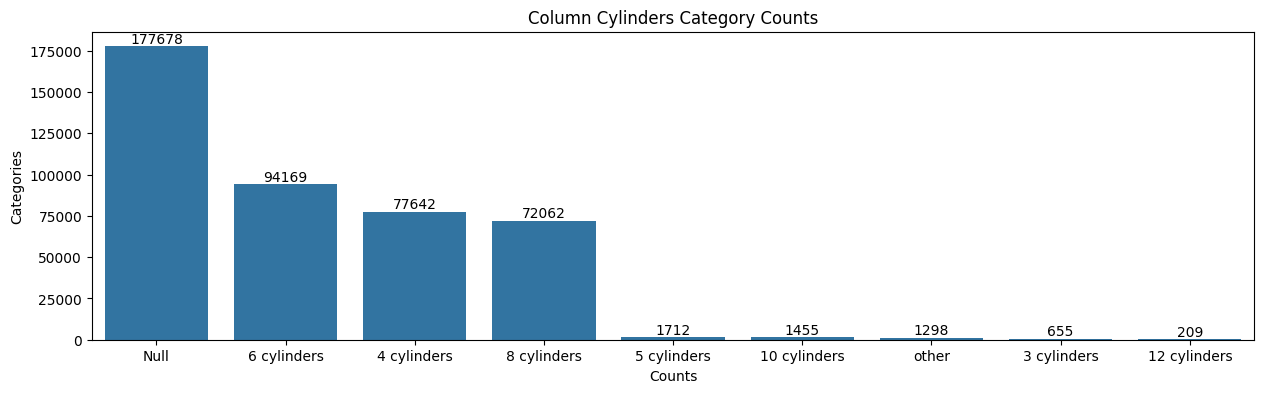

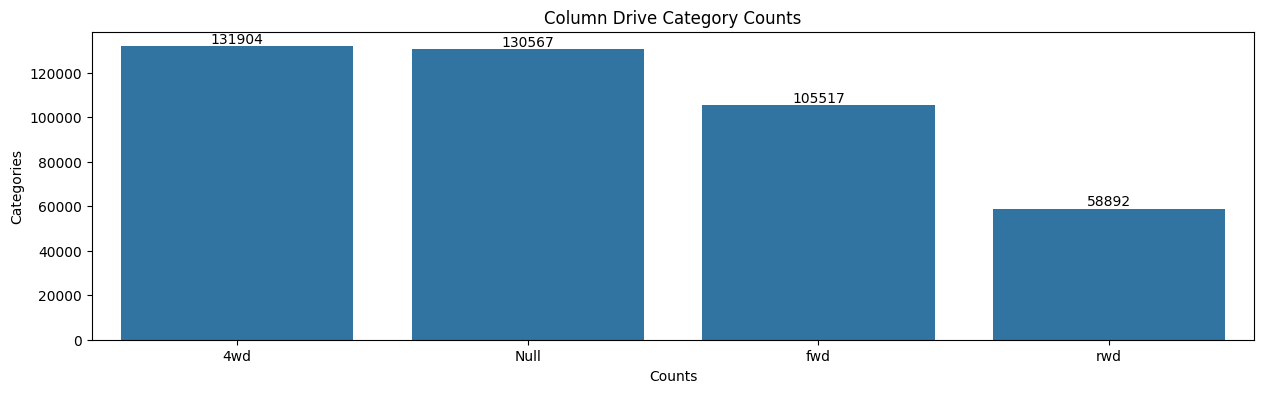

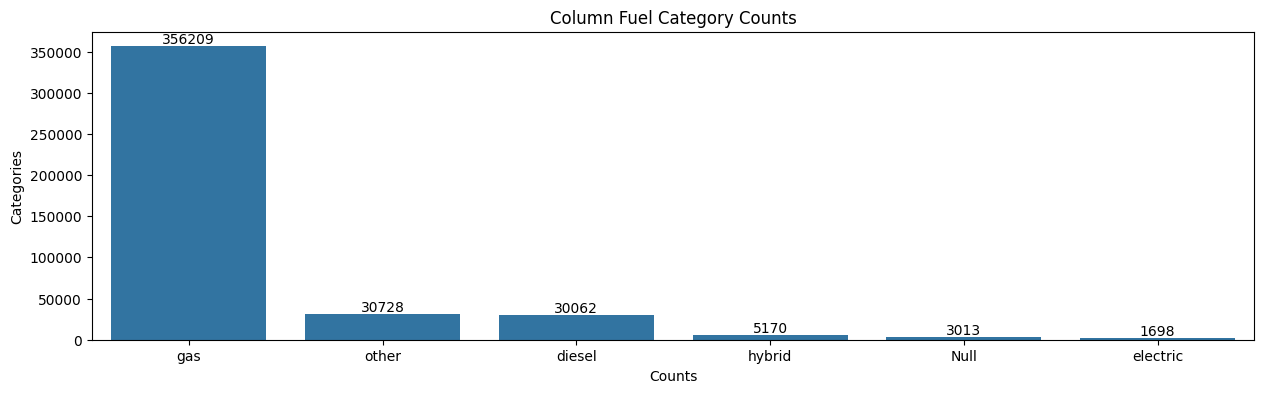

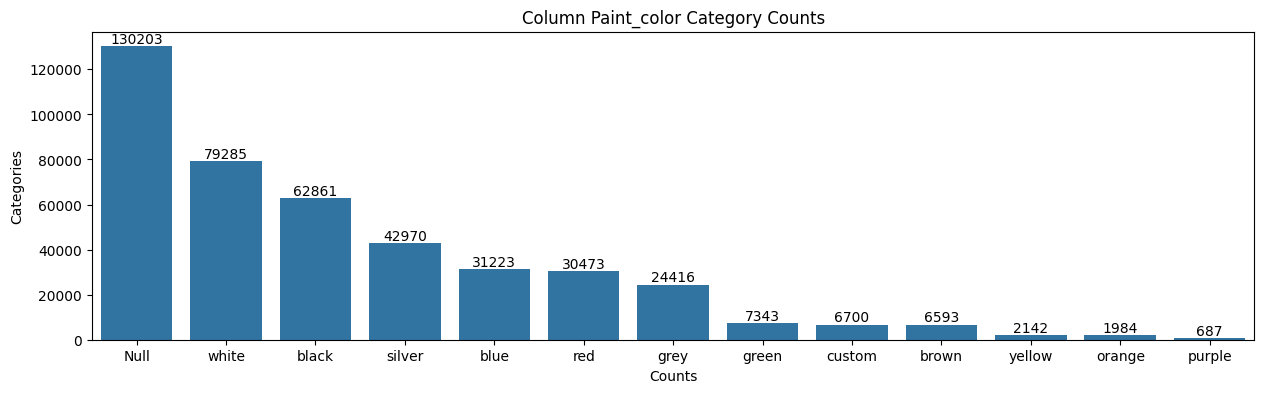

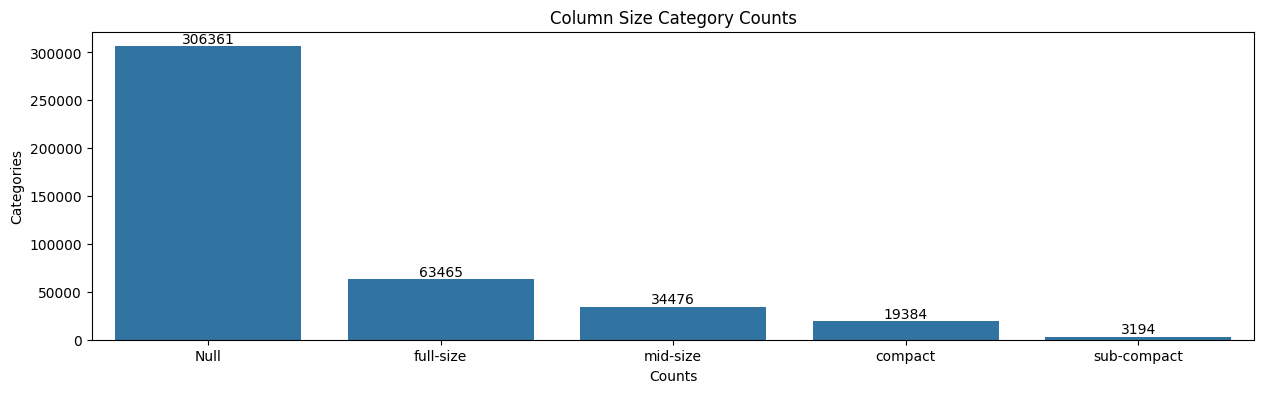

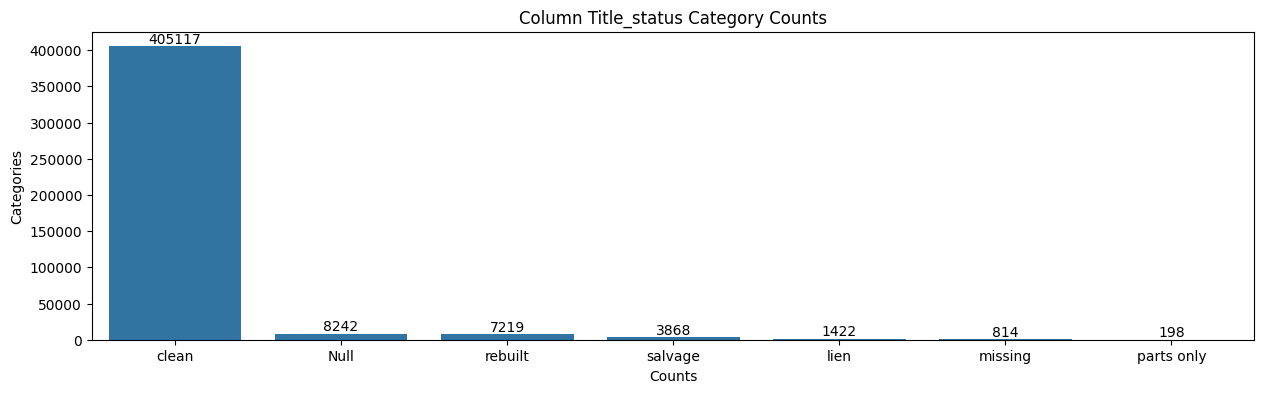

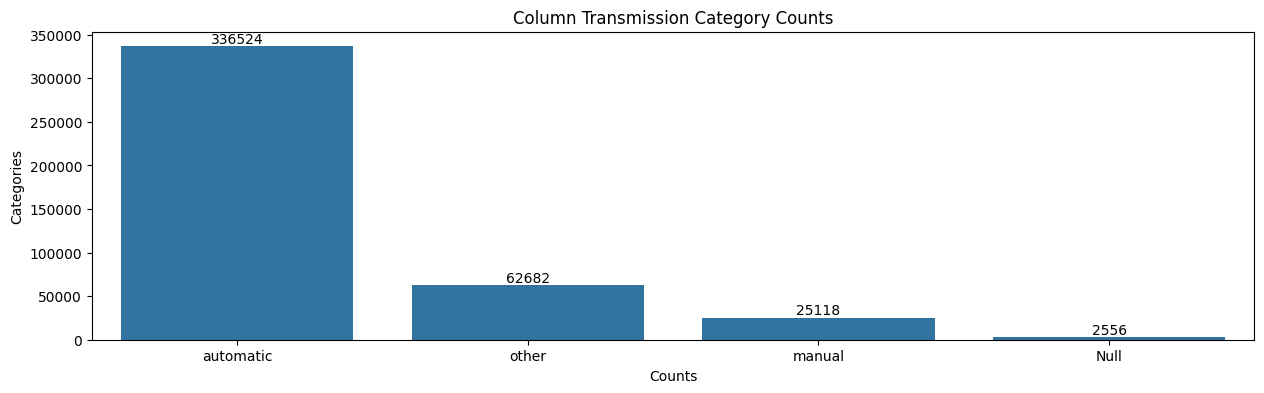

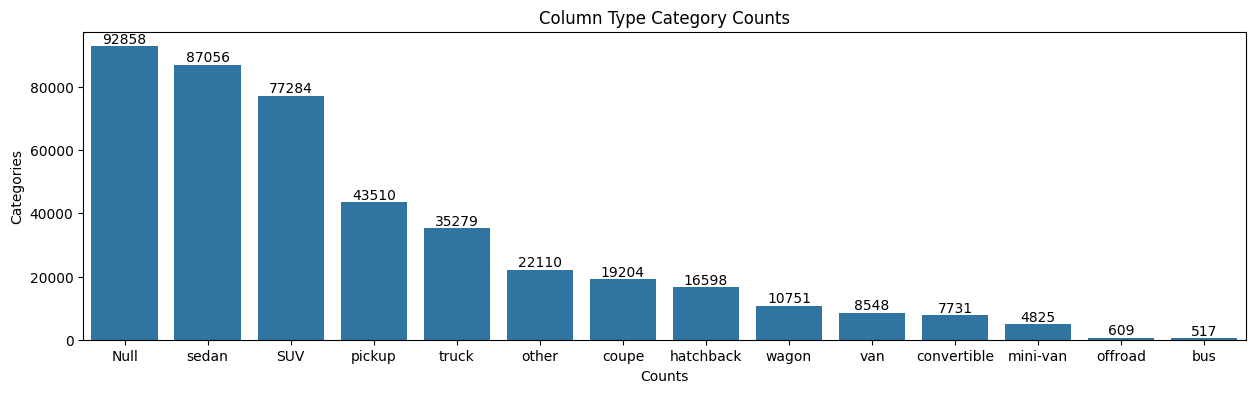

In [111]:
# Review distribution of values in columns condition, cylinders, VIN, drive, size, type, paint_color
print('Number of unique values in "model" column: ' + str(len(vehicles['model'].unique())))
print('Number of unique values in "region" column: ' + str(len(vehicles['region'].unique())))

for column in [ 'condition', 'cylinders', 'drive', 'fuel', 'paint_color', 'size', 'title_status', 'transmission', 'type' ]:
  plt.figure(figsize=(15,4))
  bar_plot = sns.barplot(x=vehicles[column].fillna('Null').value_counts(dropna=False).index, y=vehicles[column].value_counts(dropna=False))
  bar_plot.set(xlabel='Counts', ylabel='Categories', title='Column {0} Category Counts'.format(column.capitalize()))
  bar_plot.bar_label(bar_plot.containers[0])
  if column in [ 'manufacturer' ]:
    bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=90)



**Conclusion:** The "model" (29650) and "region" (404) columns have a lot of categorical values that will make it difficult to drive price.

**Analyze:** Duplicate rows.

In [112]:
vehicles[vehicles.duplicated(keep = False)]

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state


**Conclusion:** There are no duplicate values.

**Analyze:** Why 7.71% of column "price" values are 0. Are they associated with certain vehicle characteristics like "condition", "type", or "title_status".

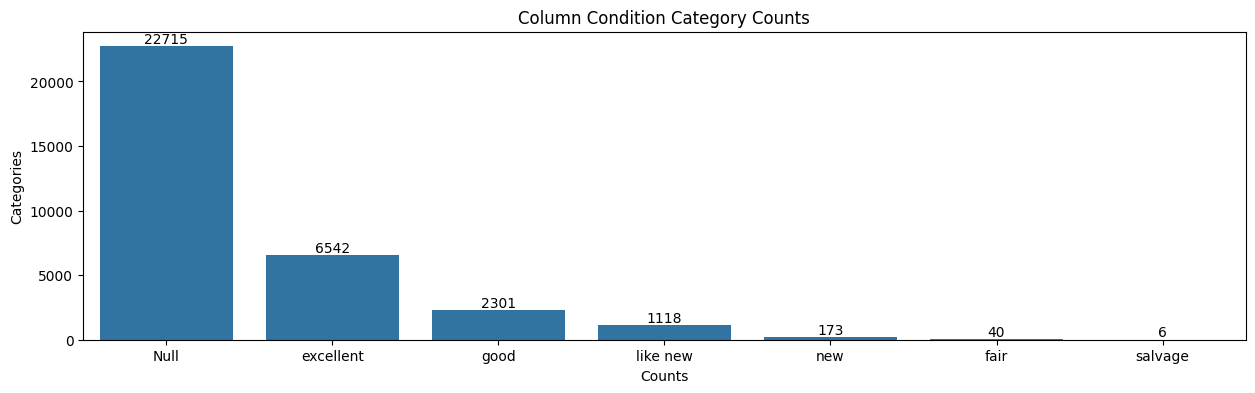

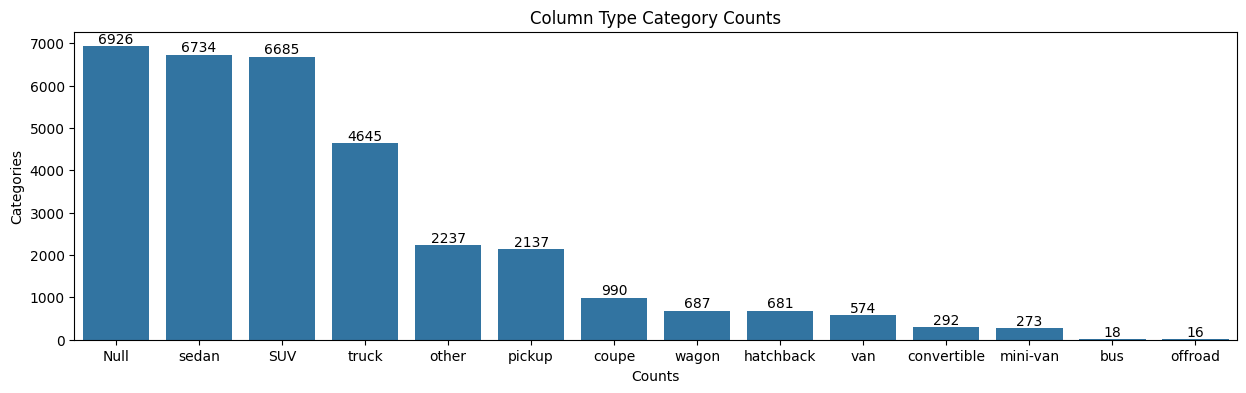

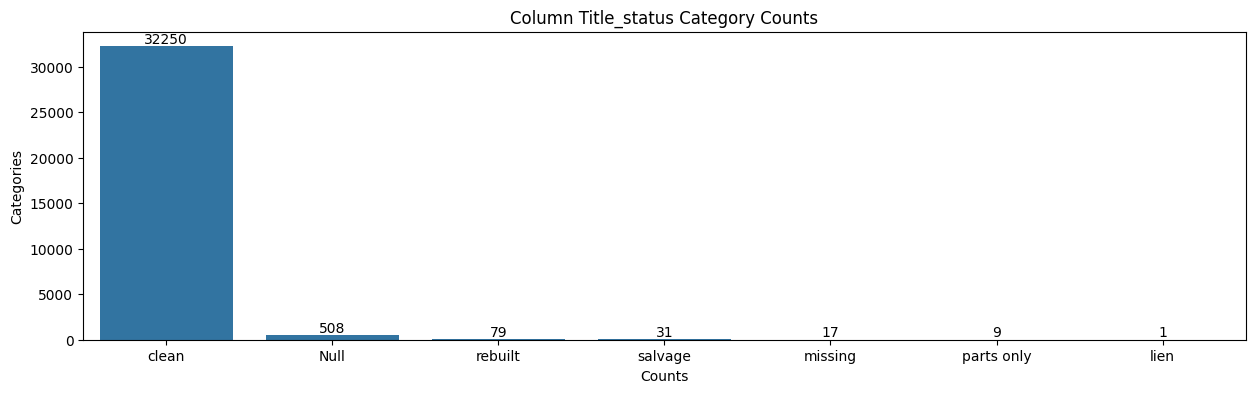

In [113]:
for column in [ 'condition', 'type', 'title_status' ]:
  plt.figure(figsize=(15,4))
  bar_plot = sns.barplot(x=vehicles[vehicles['price'].eq(0)][column].fillna('Null').value_counts(dropna=False).index, y=vehicles[vehicles['price'].eq(0)][column].value_counts(dropna=False))
  bar_plot.set(xlabel='Counts', ylabel='Categories', title='Column {0} Category Counts'.format(column.capitalize()))
  bar_plot.bar_label(bar_plot.containers[0])

**Conclusion:** The data does not show any correlation between price value 0 and the "condition", "type", or "title_status" of the vehicles.

**Analize:** The "model" column to count the number of words associated to categorical values from columns "drive", "fuel", "paint_color", "transmission", and "type".

In [114]:
def contains_word(search_word):
  def f(text):
    if text is None:
      return False

    return search_word.lower() in str(text).lower().split()

  return f

words = []
for word in [ '2wd', '4dr', '4wd', '4x4', 'automatic', 'black', 'blue', 'bus', 'brown', 'coupe', 'diesel', 'electric', 'fwd', 'gas', 'green', 'grey', 'hatchback', 'hybrid', 'manual', 'mini-van', 'minivan', 'offroad', 'orange', 'purple', 'rd', 'red', 'rwd', 'sedan', 'silver', 'suv', 'yellow', 'van', 'wagon', 'wd', 'white' ]:
  words.append({ 'Word': word, 'Count': len(vehicles[vehicles.model.apply(contains_word(word))]) })

pd.DataFrame(words)

,Word,Count
0,2wd,325
1,4dr,2054
2,4wd,2689
3,4x4,9639
4,automatic,671
5,black,149
6,blue,117
7,bus,289
8,brown,16
9,coupe,6540


**Conclusion:**: There are many text words that can be extracted from models to fill missing values in other columns.

**Analyze**: Correlation of column "price" with categorical columns by analyzing the mean price of the vehicle per categorical value

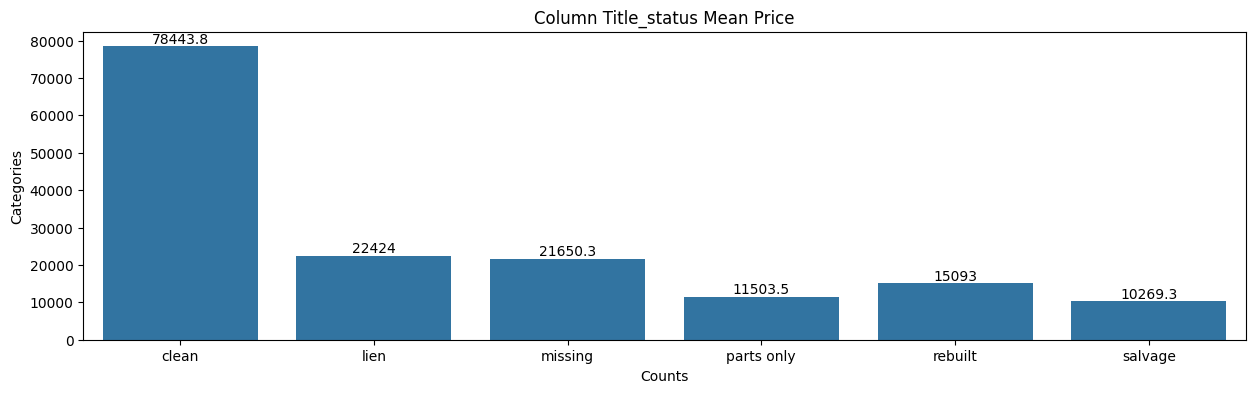

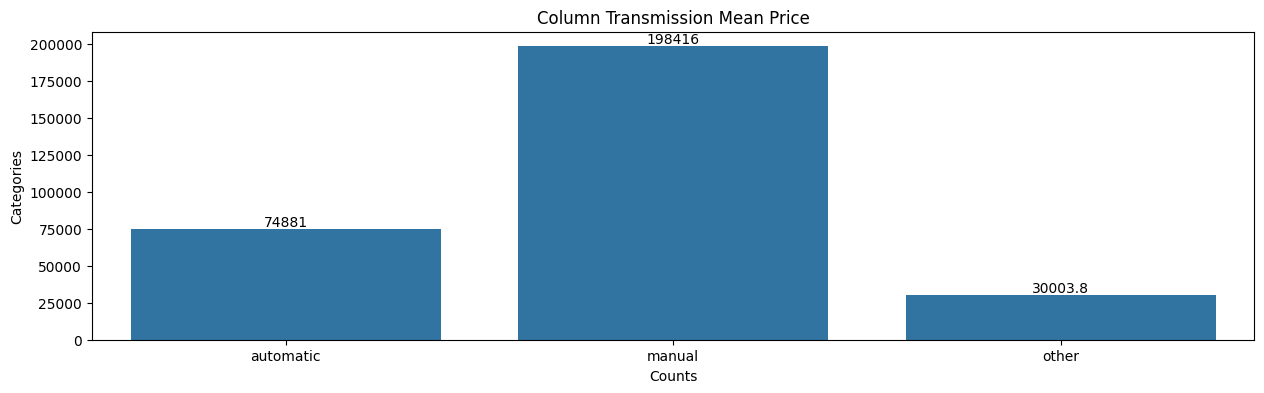

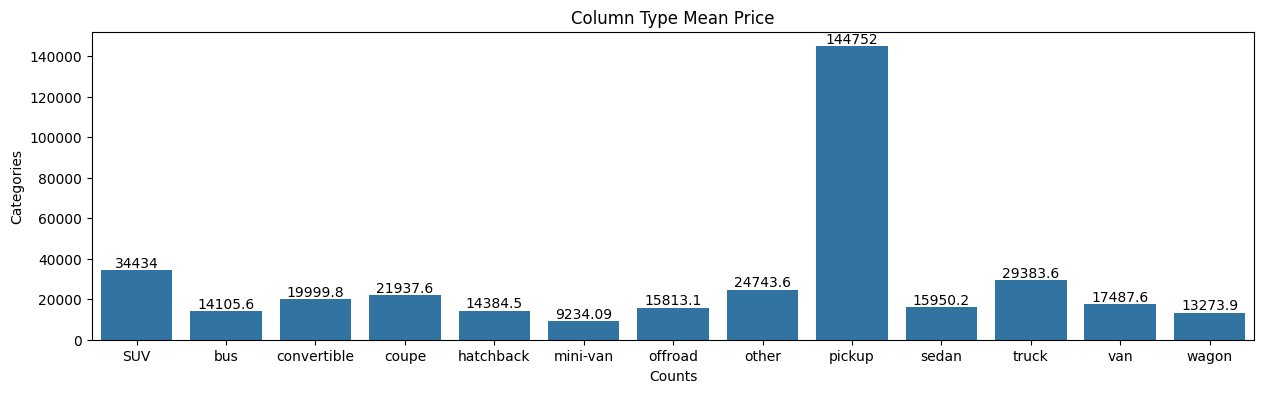

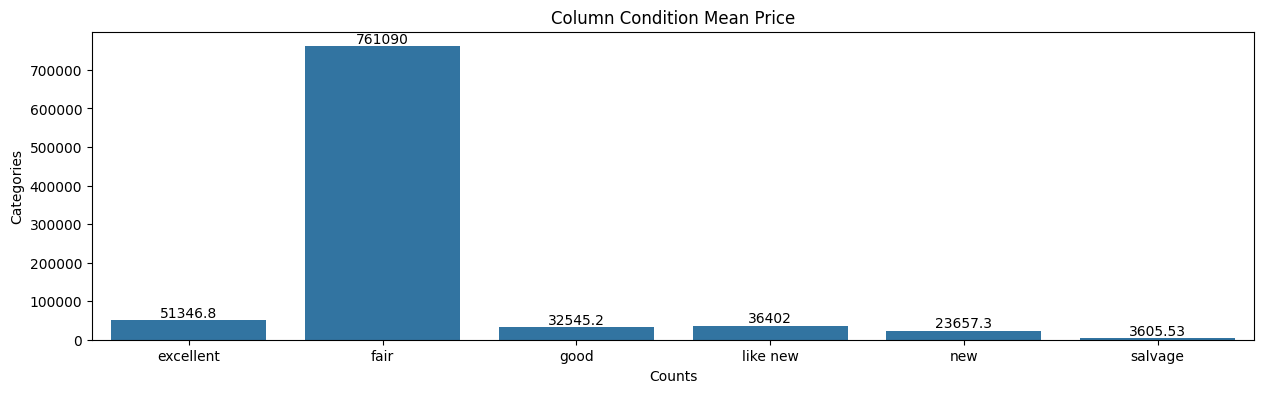

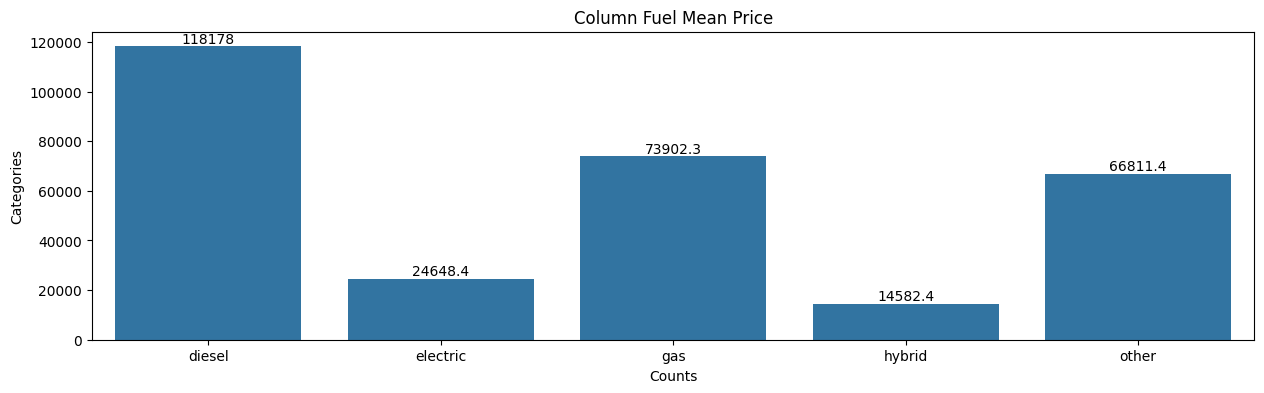

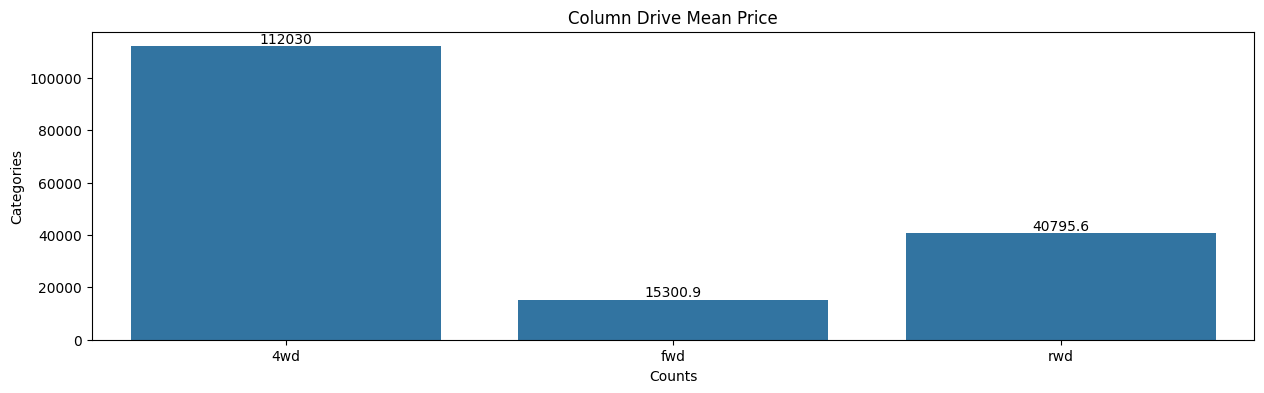

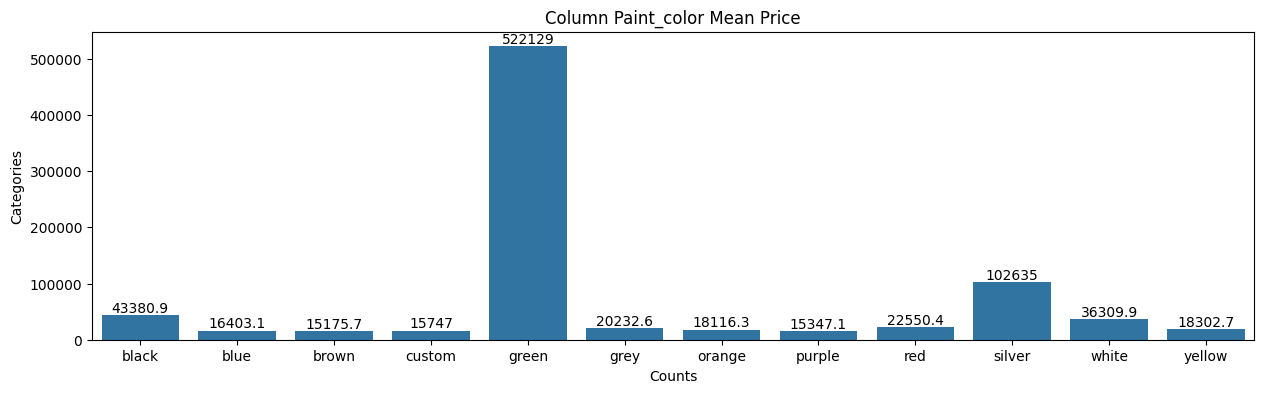

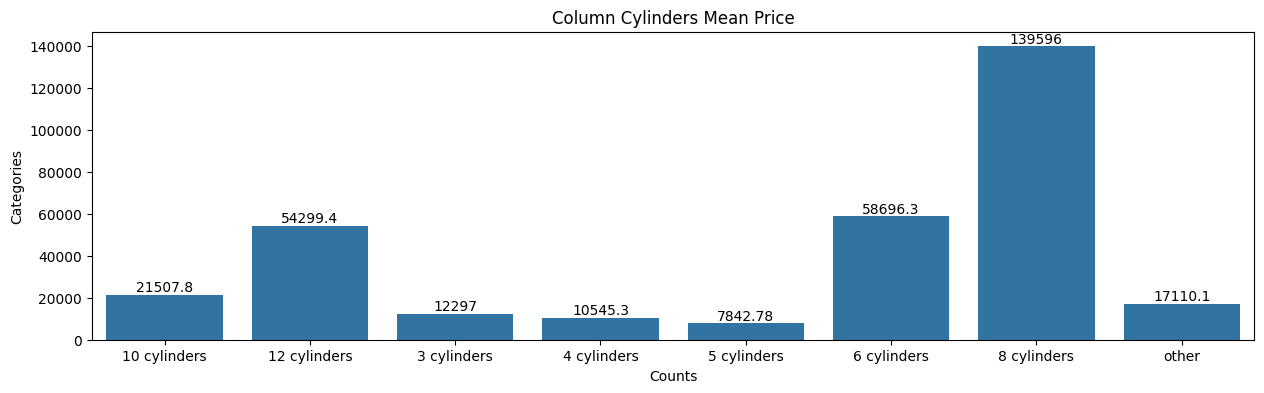

In [115]:
columns = ['title_status', 'transmission', 'type', 'condition', 'fuel', 'drive','paint_color', 'cylinders' ]

for i, column in enumerate(columns):
  plt.figure(figsize=(15,4))
  mean_price = vehicles.groupby(column)['price'].mean()
  bar_plot = sns.barplot(mean_price)
  bar_plot.set(xlabel='Counts', ylabel='Categories', title='Column {0} Mean Price'.format(column.capitalize()))
  bar_plot.bar_label(bar_plot.containers[0])
  if column in [ 'manufacturer', 'region' ]:
    bar_plot.set_xticklabels(bar_plot.get_xticklabels(), rotation=90)


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`.

**Fix Data Types:** Based on the previous analysis we can first convert all object columns to their correct data type.

In [116]:
vehicles = vehicles.convert_dtypes()
vehicles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            426880 non-null  Int64 
 1   region        426880 non-null  string
 2   price         426880 non-null  Int64 
 3   year          425675 non-null  Int64 
 4   manufacturer  409234 non-null  string
 5   model         421603 non-null  string
 6   condition     252776 non-null  string
 7   cylinders     249202 non-null  string
 8   fuel          423867 non-null  string
 9   odometer      422480 non-null  Int64 
 10  title_status  418638 non-null  string
 11  transmission  424324 non-null  string
 12  VIN           265838 non-null  string
 13  drive         296313 non-null  string
 14  size          120519 non-null  string
 15  type          334022 non-null  string
 16  paint_color   296677 non-null  string
 17  state         426880 non-null  string
dtypes: Int64(4), string(14)


**Fill Column Values:** Fill "drive", "fuel", "paint_color", "transmission", and "type" columns with missing values from the "model" column.

In [117]:
def fill_word(original_word, replacement_word):
  def f(text):
    if text is None:
      return None

    if original_word.lower() in str(text).lower().split():
      return replacement_word
    else:
      return None

  return f

vehicles['drive'] = vehicles['drive'].fillna(vehicles['model'].apply(fill_word('4dr', '4wd')))
vehicles['drive'] = vehicles['drive'].fillna(vehicles['model'].apply(fill_word('4wd', '4wd')))
vehicles['drive'] = vehicles['drive'].fillna(vehicles['model'].apply(fill_word('4x4', '4wd')))
vehicles['drive'] = vehicles['drive'].fillna(vehicles['model'].apply(fill_word('fwd', 'fwd')))
vehicles['drive'] = vehicles['drive'].fillna(vehicles['model'].apply(fill_word('rwd', 'rwd')))

vehicles['fuel'] = vehicles['fuel'].fillna(vehicles['model'].apply(fill_word('diesel', 'diesel')))
vehicles['fuel'] = vehicles['fuel'].fillna(vehicles['model'].apply(fill_word('electric', 'electric')))
vehicles['fuel'] = vehicles['fuel'].fillna(vehicles['model'].apply(fill_word('gas', 'gas')))
vehicles['fuel'] = vehicles['fuel'].fillna(vehicles['model'].apply(fill_word('hybrid', 'hybrid')))

vehicles['paint_color'] = vehicles['paint_color'].fillna(vehicles['model'].apply(fill_word('black', 'black')))
vehicles['paint_color'] = vehicles['paint_color'].fillna(vehicles['model'].apply(fill_word('blue', 'blue')))
vehicles['paint_color'] = vehicles['paint_color'].fillna(vehicles['model'].apply(fill_word('brown', 'brown')))
vehicles['paint_color'] = vehicles['paint_color'].fillna(vehicles['model'].apply(fill_word('custom', 'custom')))
vehicles['paint_color'] = vehicles['paint_color'].fillna(vehicles['model'].apply(fill_word('green', 'green')))
vehicles['paint_color'] = vehicles['paint_color'].fillna(vehicles['model'].apply(fill_word('grey', 'grey')))
vehicles['paint_color'] = vehicles['paint_color'].fillna(vehicles['model'].apply(fill_word('orange', 'orange')))
vehicles['paint_color'] = vehicles['paint_color'].fillna(vehicles['model'].apply(fill_word('purple', 'purple')))
vehicles['paint_color'] = vehicles['paint_color'].fillna(vehicles['model'].apply(fill_word('red', 'red')))
vehicles['paint_color'] = vehicles['paint_color'].fillna(vehicles['model'].apply(fill_word('silver', 'silver')))
vehicles['paint_color'] = vehicles['paint_color'].fillna(vehicles['model'].apply(fill_word('white', 'white')))
vehicles['paint_color'] = vehicles['paint_color'].fillna(vehicles['model'].apply(fill_word('yellow', 'yellow')))

vehicles['transmission'] = vehicles['transmission'].fillna(vehicles['model'].apply(fill_word('automatic', 'automatic')))
vehicles['transmission'] = vehicles['transmission'].fillna(vehicles['model'].apply(fill_word('manual', 'manual')))

vehicles['type'] = vehicles['type'].fillna(vehicles['model'].apply(fill_word('bus', 'bus')))
vehicles['type'] = vehicles['type'].fillna(vehicles['model'].apply(fill_word('convertible', 'convertible')))
vehicles['type'] = vehicles['type'].fillna(vehicles['model'].apply(fill_word('coupe', 'coupe')))
vehicles['type'] = vehicles['type'].fillna(vehicles['model'].apply(fill_word('hatchback', 'hatchback')))
vehicles['type'] = vehicles['type'].fillna(vehicles['model'].apply(fill_word('minivan', 'mini-van')))
vehicles['type'] = vehicles['type'].fillna(vehicles['model'].apply(fill_word('mini-van', 'mini-van')))
vehicles['type'] = vehicles['type'].fillna(vehicles['model'].apply(fill_word('offroad', 'offroad')))
vehicles['type'] = vehicles['type'].fillna(vehicles['model'].apply(fill_word('pickup', 'pickup')))
vehicles['type'] = vehicles['type'].fillna(vehicles['model'].apply(fill_word('sedan', 'sedan')))
vehicles['type'] = vehicles['type'].fillna(vehicles['model'].apply(fill_word('suv', 'SUV')))
vehicles['type'] = vehicles['type'].fillna(vehicles['model'].apply(fill_word('truck', 'truck')))
vehicles['type'] = vehicles['type'].fillna(vehicles['model'].apply(fill_word('van', 'van')))
vehicles['type'] = vehicles['type'].fillna(vehicles['model'].apply(fill_word('wagon', 'wagon')))

(vehicles.isnull().sum() / len(vehicles)).mul(100).round(2).astype(str).add('%').rename('Percentage of Nulls')

,Percentage of Nulls
id,0.0%
region,0.0%
price,0.0%
year,0.28%
manufacturer,4.13%
model,1.24%
condition,40.79%
cylinders,41.62%
fuel,0.7%
odometer,1.03%


**Drop Columns:** The "VIN" and "id" columns are not business information that could affect the price of the vehicle so we can drop them. Also drop the "model" column as there is too much variety of data inside the column.
We create one clean dataset dropping columns with high percentage of Null values: "condition" (40.79%),
"cylinders" (41.62%), "drive" (30.59%), "type" (21.75%), "paint_color" (30.5%), and "size" (71.39%).

In [118]:
clean_dropna_vehicles = vehicles.drop(columns=['id', 'condition', 'cylinders', 'drive', 'type', 'model', 'paint_color', 'size', 'VIN'])
clean_dropna_vehicles.dropna(inplace=True)
clean_dropna_vehicles.drop(clean_dropna_vehicles[clean_dropna_vehicles['price'].eq(0) | clean_dropna_vehicles['price'].gt(100000)].index, inplace=True)
clean_dropna_vehicles.info()
print('Percentage of rows dropped: ' + str(round((1 - len(clean_dropna_vehicles) / len(vehicles)) * 100, 2)) + '%')

<class 'pandas.core.frame.DataFrame'>
Index: 365185 entries, 27 to 426879
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   region        365185 non-null  string
 1   price         365185 non-null  Int64 
 2   year          365185 non-null  Int64 
 3   manufacturer  365185 non-null  string
 4   fuel          365185 non-null  string
 5   odometer      365185 non-null  Int64 
 6   title_status  365185 non-null  string
 7   transmission  365185 non-null  string
 8   state         365185 non-null  string
dtypes: Int64(3), string(6)
memory usage: 28.9 MB
Percentage of rows dropped: 14.45%


After dropping the Null values and reducing the price to the > 0 <= 100.000 range we only loose 14.45% of the data.

**Fill Null wth Mode:** Use the mode of each categorical column to create another clean dataset with the mode. The "size" column is missing 71.39% of the data, we can drop this column.

In [119]:
clean_mode_vehicles = vehicles.drop(columns=['id', 'model', 'size', 'VIN'])
clean_mode_vehicles['condition'] = clean_mode_vehicles['condition'].fillna('good')
clean_mode_vehicles['cylinders'] = clean_mode_vehicles['cylinders'].fillna('6 cylinders')
clean_mode_vehicles['drive'] = clean_mode_vehicles['drive'].fillna('4wd')
clean_mode_vehicles['fuel'] = clean_mode_vehicles['fuel'].fillna('gas')
clean_mode_vehicles['manufacturer'] = clean_mode_vehicles['manufacturer'].fillna('ford')
clean_mode_vehicles['paint_color'] = clean_mode_vehicles['paint_color'].fillna('white')
clean_mode_vehicles['region'] = clean_mode_vehicles['region'].fillna('ca')
clean_mode_vehicles['state'] = clean_mode_vehicles['state'].fillna('ca')
clean_mode_vehicles['title_status'] = clean_mode_vehicles['title_status'].fillna('clean')
clean_mode_vehicles['transmission'] = clean_mode_vehicles['transmission'].fillna('automatic')
clean_mode_vehicles['type'] = clean_mode_vehicles['type'].fillna('sedan')
clean_mode_vehicles.drop(clean_mode_vehicles[clean_mode_vehicles['price'].eq(0) | clean_mode_vehicles['price'].gt(100000)].index, inplace=True)
clean_mode_vehicles.dropna(inplace=True)
print('Percentage of rows dropped: ' + str(round((1 - len(clean_mode_vehicles) / len(vehicles)) * 100, 2)) + '%')

Percentage of rows dropped: 8.65%


After replacing the missing values with the mode and reducing the price to the > 0 <= 100.000 range we only loose 8.65% of the data.


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

**Support Functions:** We create a support function to run the model and save the result metrics.

In [120]:
models = []

def run_model(model_name, model_pipe, model_X_train, model_X_test, model_y_train, model_y_test):
  model_pipe.fit(model_X_train, model_y_train)
  model_pred_train = model_pipe.predict(model_X_train)
  model_pred_test = model_pipe.predict(model_X_test)
  model_train_mse = mean_squared_error(model_y_train, model_pred_train)
  model_train_mae = mean_absolute_error(model_y_train, model_pred_train)
  model_test_mse = mean_squared_error(model_y_test, model_pred_test)
  model_test_mae = mean_absolute_error(model_y_test, model_pred_test)
  r2 = r2_score(model_y_test, model_pred_test)
  models.append({ 'Model': model_name, 'Train MSE': model_train_mse, 'Test MSE': model_test_mse, 'Train MAE': model_train_mae, 'Test MAE': model_test_mae, 'R2 Score': r2 })
  print(f'{model_name} Train MSE: {model_train_mse: .2f}')
  print(f'{model_name} Test MSE: {model_test_mse: .2f}')
  print(f'{model_name} Train MAE: {model_train_mae: .2f}')
  print(f'{model_name} Test MAE: {model_test_mae: .2f}')
  print(f'{model_name} R2 Score: {r2: .2f}')

**Split into Train and Test DataSets:**: Split into the train and test datasets.

In [121]:
model_X_train, model_X_test, model_y_train, model_y_test = train_test_split(clean_dropna_vehicles.drop('price', axis = 1), clean_dropna_vehicles['price'], test_size=0.2, random_state=32)

**Model 1:** Using the clean data with the dropped Null values, create a linear regression using One Hot Encoder to encode the categorical columns.

In [122]:
model_transformer = make_column_transformer((OneHotEncoder(),
                                             ['region', 'manufacturer', 'fuel', 'title_status', 'transmission', 'state']),
                                             remainder='passthrough')
model_pipe = Pipeline([('transformer', model_transformer), ('linreg', LinearRegression())])
run_model('Model with Dropped Null Values and One Hot Encoder', model_pipe, model_X_train, model_X_test, model_y_train, model_y_test)

Model with Dropped Null Values and One Hot Encoder Train MSE:  175082074.51
Model with Dropped Null Values and One Hot Encoder Test MSE:  172894934.57
Model with Dropped Null Values and One Hot Encoder Train MAE:  10111.03
Model with Dropped Null Values and One Hot Encoder Test MAE:  10066.09
Model with Dropped Null Values and One Hot Encoder R2 Score:  0.15


**Model 2:** Using the clean data with the dropped Null values, create a linear regression using One Hot Encoder to encode the categorical columns and Standard Scaler to scale the numerical columns.

In [123]:
model_transformer = make_column_transformer((OneHotEncoder(),
                                             ['region', 'manufacturer', 'fuel', 'title_status', 'transmission', 'state']),
                                            (StandardScaler(),
                                             ['odometer', 'year']),
                                             remainder='passthrough')
model_pipe = Pipeline([('transformer', model_transformer), ('linreg', LinearRegression())])
run_model('Model with Dropped Null Values, One Hot Encoder, and StandardScaler', model_pipe, model_X_train, model_X_test, model_y_train, model_y_test)


Model with Dropped Null Values, One Hot Encoder, and StandardScaler Train MSE:  123664910.92
Model with Dropped Null Values, One Hot Encoder, and StandardScaler Test MSE:  123814553.21
Model with Dropped Null Values, One Hot Encoder, and StandardScaler Train MAE:  7937.98
Model with Dropped Null Values, One Hot Encoder, and StandardScaler Test MAE:  7961.10
Model with Dropped Null Values, One Hot Encoder, and StandardScaler R2 Score:  0.39


**Model 3:** Using the clean data with the dropped Null values, create a linear regression using One Hot Encoder to encode the categorical columns and the Polynomial Features to the numerical columns.

In [124]:
model_transformer = make_column_transformer((OneHotEncoder(),
                                             ['fuel', 'title_status', 'transmission', 'region', 'manufacturer', 'state']),
                                            (PolynomialFeatures(include_bias = False),
                                             ['odometer', 'year']),
                                             remainder='passthrough')
model_pipe = Pipeline([('transformer', model_transformer), ('linreg', LinearRegression())])
grid = GridSearchCV(model_pipe, {'transformer__polynomialfeatures__degree': [ 2, 3, 4 ]})
run_model('Model with Dropped Null Values, One Hot Encoder, and Polynomial Features', grid, model_X_train, model_X_test, model_y_train, model_y_test)

Model with Dropped Null Values, One Hot Encoder, and Polynomial Features Train MSE:  167654446.34
Model with Dropped Null Values, One Hot Encoder, and Polynomial Features Test MSE:  164879287.12
Model with Dropped Null Values, One Hot Encoder, and Polynomial Features Train MAE:  9613.37
Model with Dropped Null Values, One Hot Encoder, and Polynomial Features Test MAE:  9560.69
Model with Dropped Null Values, One Hot Encoder, and Polynomial Features R2 Score:  0.19


**Model 4:** Using the clean data with the dropped Null values, create a linear regression using One Hot Encoder and James Stein Encoder to encode the categorical columns.

In [125]:
model_transformer = make_column_transformer((OneHotEncoder(),
                                             ['fuel', 'title_status', 'transmission']),
                                             (JamesSteinEncoder(),
                                             ['region', 'manufacturer', 'state']),
                                             remainder='passthrough')
model_pipe = Pipeline([('transformer', model_transformer), ('linreg', LinearRegression())])
run_model('Model with Dropped Null Values, One Hot Encoder, and James Stein Encoder', model_pipe, model_X_train, model_X_test, model_y_train, model_y_test)


Model with Dropped Null Values, One Hot Encoder, and James Stein Encoder Train MSE:  127756496.28
Model with Dropped Null Values, One Hot Encoder, and James Stein Encoder Test MSE:  127538838.24
Model with Dropped Null Values, One Hot Encoder, and James Stein Encoder Train MAE:  8121.87
Model with Dropped Null Values, One Hot Encoder, and James Stein Encoder Test MAE:  8133.84
Model with Dropped Null Values, One Hot Encoder, and James Stein Encoder R2 Score:  0.38


**Model 5:** Using the clean data with the dropped Null values, create a linear regression using One Hot Encoder and James Stein Encoder to encode the categorical columns, and the Polynomial Features.

In [126]:
model_transformer = make_column_transformer((OneHotEncoder(),
                                             ['fuel', 'title_status', 'transmission']),
                                             (JamesSteinEncoder(),
                                             ['region', 'manufacturer', 'state']),
                                             (PolynomialFeatures(include_bias = False),
                                             ['odometer', 'year']),
                                             remainder='passthrough')
model_pipe = Pipeline([('transformer', model_transformer), ('linreg', LinearRegression())])
grid = GridSearchCV(model_pipe, {'transformer__polynomialfeatures__degree': [ 2, 3, 4 ]})
run_model('Model with Dropped Null Values, One Hot Encoder, James Stein Encoder, and Polynomial Features', grid, model_X_train, model_X_test, model_y_train, model_y_test)

Model with Dropped Null Values, One Hot Encoder, James Stein Encoder, and Polynomial Features Train MSE:  128289123.43
Model with Dropped Null Values, One Hot Encoder, James Stein Encoder, and Polynomial Features Test MSE:  127162374.45
Model with Dropped Null Values, One Hot Encoder, James Stein Encoder, and Polynomial Features Train MAE:  8048.58
Model with Dropped Null Values, One Hot Encoder, James Stein Encoder, and Polynomial Features Test MAE:  8052.69
Model with Dropped Null Values, One Hot Encoder, James Stein Encoder, and Polynomial Features R2 Score:  0.38


**Split into Train and Test DataSets:** Split the clean data filled with the mode into train and test data sets.

In [127]:
model_X_train, model_X_test, model_y_train, model_y_test = train_test_split(clean_mode_vehicles.drop('price', axis = 1), clean_mode_vehicles['price'], test_size=0.2, random_state=32)

**Model 6:** Using the clean data with the mode values, create a linear regression using One Hot Encoder.

In [128]:
model_transformer = make_column_transformer((OneHotEncoder(),
                                             ['condition', 'cylinders', 'drive', 'fuel', 'manufacturer', 'paint_color', 'region', 'state', 'title_status', 'transmission', 'type']),
                                             remainder='passthrough')
model_pipe = Pipeline([('transformer', model_transformer), ('linreg', LinearRegression())])
run_model('Model with Mode Values and One Hot Encoder', model_pipe, model_X_train, model_X_test, model_y_train, model_y_test)

Model with Mode Values and One Hot Encoder Train MSE:  135005379.16
Model with Mode Values and One Hot Encoder Test MSE:  135147966.03
Model with Mode Values and One Hot Encoder Train MAE:  8350.38
Model with Mode Values and One Hot Encoder Test MAE:  8367.01
Model with Mode Values and One Hot Encoder R2 Score:  0.35


**Model 7:** Using the clean data with the mode values, create a linear regression using One Hot Encoder, and Standard Scaler to scale the numerical columns.

In [129]:
model_transformer = make_column_transformer((OneHotEncoder(),
                                             ['condition', 'cylinders', 'drive', 'fuel', 'manufacturer', 'paint_color', 'region', 'state', 'title_status', 'transmission', 'type']),
                                             (StandardScaler(),
                                             ['odometer', 'year']),
                                             remainder='passthrough')
model_pipe = Pipeline([('transformer', model_transformer), ('linreg', LinearRegression())])
run_model('Model with Mode Values, One Hot Encoder, and Standard Scaler', model_pipe, model_X_train, model_X_test, model_y_train, model_y_test)

Model with Mode Values, One Hot Encoder, and Standard Scaler Train MSE:  115994138.16
Model with Mode Values, One Hot Encoder, and Standard Scaler Test MSE:  117054277.84
Model with Mode Values, One Hot Encoder, and Standard Scaler Train MAE:  7565.66
Model with Mode Values, One Hot Encoder, and Standard Scaler Test MAE:  7606.05
Model with Mode Values, One Hot Encoder, and Standard Scaler R2 Score:  0.44


This is the best model. Extract the coefficients.

In [130]:
coef = dict(zip(model_transformer.get_feature_names_out(), model_pipe['linreg'].coef_))
coef = [{ 'Feature Name': k, 'Coefficient': v } for k, v in sorted(coef.items(), key=lambda item: item[1])]


**Model 8:** Using the clean data with the mode values, create a linear regression using One Hot **Encoder**, and the Polynomial Features.

In [131]:
model_transformer = make_column_transformer((OneHotEncoder(),
                                             ['condition', 'cylinders', 'drive', 'fuel', 'manufacturer', 'paint_color', 'region', 'state', 'title_status', 'transmission', 'type']),
                                            (PolynomialFeatures(include_bias = False),
                                             ['odometer', 'year']),
                                             remainder='passthrough')
model_pipe = Pipeline([('transformer', model_transformer), ('linreg', LinearRegression())])
grid = GridSearchCV(model_pipe, {'transformer__polynomialfeatures__degree': [ 2, 3, 4 ]})
run_model('Model with Mode Values, One Hot Encoder, and Polynomial Features', grid, model_X_train, model_X_test, model_y_train, model_y_test)

Model with Mode Values, One Hot Encoder, and Polynomial Features Train MSE:  177001669.41
Model with Mode Values, One Hot Encoder, and Polynomial Features Test MSE:  175653709.43
Model with Mode Values, One Hot Encoder, and Polynomial Features Train MAE:  9964.51
Model with Mode Values, One Hot Encoder, and Polynomial Features Test MAE:  9930.70
Model with Mode Values, One Hot Encoder, and Polynomial Features R2 Score:  0.16


**Model 9:** Using the clean data with the mode values, create a linear regression using One Hot Encoder and James Stein Encoder to encode the categorical columns.

In [132]:
model_transformer = make_column_transformer((OneHotEncoder(),
                                             ['condition', 'cylinders', 'drive', 'fuel', 'paint_color', 'title_status', 'transmission', 'type']),
                                            (JamesSteinEncoder(),
                                             ['region', 'manufacturer', 'state']),
                                             remainder='passthrough')
model_pipe = Pipeline([('transformer', model_transformer), ('linreg', LinearRegression())])
run_model('Model with Mode Values, One Hot Encoder, James Stein Encoder, and Polynomial Features', model_pipe, model_X_train, model_X_test, model_y_train, model_y_test)

Model with Mode Values, One Hot Encoder, James Stein Encoder, and Polynomial Features Train MSE:  153649713.71
Model with Mode Values, One Hot Encoder, James Stein Encoder, and Polynomial Features Test MSE:  153645255.91
Model with Mode Values, One Hot Encoder, James Stein Encoder, and Polynomial Features Train MAE:  9162.22
Model with Mode Values, One Hot Encoder, James Stein Encoder, and Polynomial Features Test MAE:  9191.16
Model with Mode Values, One Hot Encoder, James Stein Encoder, and Polynomial Features R2 Score:  0.26


**Model 10:** Using the clean data with the mode values, create a linear regression using One Hot Encoder and James Stein Encoder to encode the categorical columns, and Standard Scaler to scale the numerical columns.

In [133]:
model_transformer = make_column_transformer((OneHotEncoder(),
                                             ['condition', 'cylinders', 'drive', 'fuel', 'paint_color', 'title_status', 'transmission', 'type']),
                                            (JamesSteinEncoder(),
                                             ['region', 'manufacturer', 'state']),
                                            (StandardScaler(),
                                             ['odometer', 'year']),
                                             remainder='passthrough')
model_pipe = Pipeline([('transformer', model_transformer), ('linreg', LinearRegression())])
run_model('Model with Mode Values, One Hot Encoder, James Stein Encoder, and Standard Scaler', model_pipe, model_X_train, model_X_test, model_y_train, model_y_test)

Model with Mode Values, One Hot Encoder, James Stein Encoder, and Standard Scaler Train MSE:  119468473.35
Model with Mode Values, One Hot Encoder, James Stein Encoder, and Standard Scaler Test MSE:  119920417.22
Model with Mode Values, One Hot Encoder, James Stein Encoder, and Standard Scaler Train MAE:  7695.26
Model with Mode Values, One Hot Encoder, James Stein Encoder, and Standard Scaler Test MAE:  7729.30
Model with Mode Values, One Hot Encoder, James Stein Encoder, and Standard Scaler R2 Score:  0.43


**Model 11:** Using the clean data with the mode values, create a linear regression using One Hot Encoder and James Stein Encoder to encode the categorical columns, and the Polynomial Features.

In [134]:
model_transformer = make_column_transformer((OneHotEncoder(),
                                             ['condition', 'cylinders', 'drive', 'fuel', 'manufacturer', 'paint_color', 'region', 'state', 'title_status', 'transmission', 'type']),
                                             (JamesSteinEncoder(),
                                             ['region', 'manufacturer', 'state']),
                                             (PolynomialFeatures(include_bias = False),
                                             ['odometer', 'year']),
                                             remainder='passthrough')
model_pipe = Pipeline([('transformer', model_transformer), ('linreg', LinearRegression())])
grid = GridSearchCV(model_pipe, {'transformer__polynomialfeatures__degree': [ 2, 3, 4 ]})
run_model('Model with Mode Values, One Hot Encoder, James Stein Encoder, and Polynomial Features', grid, model_X_train, model_X_test, model_y_train, model_y_test)

Model with Mode Values, One Hot Encoder, James Stein Encoder, and Polynomial Features Train MSE:  177001669.39
Model with Mode Values, One Hot Encoder, James Stein Encoder, and Polynomial Features Test MSE:  175653709.42
Model with Mode Values, One Hot Encoder, James Stein Encoder, and Polynomial Features Train MAE:  9964.51
Model with Mode Values, One Hot Encoder, James Stein Encoder, and Polynomial Features Test MAE:  9930.70
Model with Mode Values, One Hot Encoder, James Stein Encoder, and Polynomial Features R2 Score:  0.16


**Model 12:** Using the clean data with the mode values, create a linear regression using One Hot Encoder and James Stein Encoder to encode the categorical columns, Standard Scaler to scale the numerical columns, and the Polynomial Features.

In [135]:
model_transformer = make_column_transformer((OneHotEncoder(),
                                             ['condition', 'cylinders', 'drive', 'fuel', 'paint_color', 'title_status', 'transmission', 'type']),
                                             (JamesSteinEncoder(),
                                             ['region', 'manufacturer', 'state']),
                                             (StandardScaler(),
                                             ['odometer', 'year']),
                                             (PolynomialFeatures(include_bias = False),
                                             ['odometer', 'year']),
                                             remainder='passthrough')
model_pipe = Pipeline([('transformer', model_transformer), ('linreg', LinearRegression())])
grid = GridSearchCV(model_pipe, {'transformer__polynomialfeatures__degree': [ 2, 3, 4 ]})
run_model('Model with Mode Values, One Hot Encoder, James Stein Encoder, Standard Scaler, and Polynomial Features', grid, model_X_train, model_X_test, model_y_train, model_y_test)

Model with Mode Values, One Hot Encoder, James Stein Encoder, Standard Scaler, and Polynomial Features Train MSE:  168610785.26
Model with Mode Values, One Hot Encoder, James Stein Encoder, Standard Scaler, and Polynomial Features Test MSE:  167268617.79
Model with Mode Values, One Hot Encoder, James Stein Encoder, Standard Scaler, and Polynomial Features Train MAE:  9636.66
Model with Mode Values, One Hot Encoder, James Stein Encoder, Standard Scaler, and Polynomial Features Test MAE:  9594.65
Model with Mode Values, One Hot Encoder, James Stein Encoder, Standard Scaler, and Polynomial Features R2 Score:  0.20


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

**Evaluation**: In the model evaluation table we can see that the model with the highest R2 Score is "Model with Mode Values, One Hot Encoder, James Stein Encoder, and Standard Scaler". Still it is important to explain to the customer that this model only explains 43.9% of the price.

In [136]:
pd.DataFrame(models)

,Model,Train MSE,Test MSE,Train MAE,Test MAE,R2 Score
0,Model with Dropped Null Values and One Hot Enc...,1.750821e+08,1.728949e+08,10111.034663,10066.085009,0.152919
1,"Model with Dropped Null Values, One Hot Encode...",1.236649e+08,1.238146e+08,7937.984372,7961.097698,0.393383
2,"Model with Dropped Null Values, One Hot Encode...",1.676544e+08,1.648793e+08,9613.368419,9560.692224,0.192191
3,"Model with Dropped Null Values, One Hot Encode...",1.277565e+08,1.275388e+08,8121.873562,8133.838587,0.375136
4,"Model with Dropped Null Values, One Hot Encode...",1.282891e+08,1.271624e+08,8048.580759,8052.685375,0.376981
5,Model with Mode Values and One Hot Encoder,1.350054e+08,1.351480e+08,8350.376367,8367.014400,0.353207
6,"Model with Mode Values, One Hot Encoder, and S...",1.159941e+08,1.170543e+08,7565.661091,7606.046612,0.439800
7,"Model with Mode Values, One Hot Encoder, and P...",1.770017e+08,1.756537e+08,9964.514608,9930.699068,0.159354
8,"Model with Mode Values, One Hot Encoder, James...",1.536497e+08,1.536453e+08,9162.218281,9191.156149,0.264682
9,"Model with Mode Values, One Hot Encoder, James...",1.194685e+08,1.199204e+08,7695.260494,7729.302955,0.426083


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

**Deployment**: Based on our findings, the price is mostly driven negatively by region/state, type, and title status. Coupe and "other" types of cars reduce the price. Also regions like Columbia, Florence, Baton, sell cars at lower prices. The status of the title if it's lien or missing also reduces the price. The price is mostly driven positiely by region and manufacturer. The price will be higher if it comes from manufacturers like Ferrari, Aston Martin, Tesla, Datsun, and Porcsche. The price will be higher if the vehicle is sold in regions like  Louisville, Western KY, Bowling Green, Lexington, Owensboro, and Eastern Kentucky.

In [137]:
pd.DataFrame(coef)

,Feature Name,Coefficient
0,onehotencoder__state_ky,-24373.787056
1,onehotencoder__manufacturer_morgan,-18091.983412
2,onehotencoder__manufacturer_harley-davidson,-8971.158467
3,onehotencoder__manufacturer_fiat,-8500.603869
4,onehotencoder__region_klamath falls,-8399.109149
...,...,...
550,onehotencoder__region_bowling green,25181.685055
551,onehotencoder__region_lexington,25295.091060
552,onehotencoder__region_owensboro,25617.949841
553,onehotencoder__region_eastern kentucky,26533.003152
